# Investigating Time

## The code here is exactly like CNN-LSTM Model


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf #for training of deep neural networks
from tensorflow.keras.layers import Embedding #for a real-valued vector representation
from tensorflow.keras.preprocessing.sequence import pad_sequences #to make the input length fixed
from tensorflow.keras.models import Sequential #to create a sequential model
from tensorflow.keras.preprocessing.text import one_hot #to convert sentences into one-hot representations given the vocabulary size
from tensorflow.keras.layers import LSTM #to process the sequences of data
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense #receives input from its previous layer
from tensorflow.keras.layers import MaxPooling1D
from keras.callbacks import Callback

from timeit import default_timer as timer
import time

from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
#If you didn't run the preprocess codes you can used the already preprocessed 
#data by changing the first and the third line of code with the following.
#df_news = pd.read_csv('..\\..\\Datasets\\Preprocessed\\df_preprocessed_news', index_col=0)
#df_germanFakeNC = pd.read_csv('..\\..\\Datasets\\Preprocessed\\df_preprocessed_GermanFakeNC', index_col=0)

df_news = pd.read_csv('..\\..\\Datasets\\news\\df_preprocessed_news', index_col=0)
df_news = df_news.sample(frac=1).reset_index(drop=True)

df_germanFakeNC = pd.read_csv('..\\..\\Datasets\\GermanFakeNC\\df_preprocessed_GermanFakeNC', index_col=0)
df_germanFakeNC = df_germanFakeNC.sample(frac=1).reset_index(drop=True)

df_combined = pd.concat([df_news.reset_index(drop=True),df_germanFakeNC.reset_index(drop=True)], axis=0)
df_combined = df_combined.sample(frac=1).reset_index(drop=True)

vocab=20000
onehot_repr_news=[one_hot(words,vocab)for words in df_news['Text']]
onehot_repr_germanFakeNC=[one_hot(words,vocab)for words in df_germanFakeNC['Text']]
onehot_repr_combined=[one_hot(words,vocab)for words in df_combined['Text']]

length = 100
embedded_docs_news=pad_sequences(onehot_repr_news,padding='pre',maxlen=length)
embedded_docs_germanFakeNC=pad_sequences(onehot_repr_germanFakeNC,padding='pre',maxlen=length)
embedded_docs_combined=pad_sequences(onehot_repr_combined,padding='pre',maxlen=length)

embedding_vector_features=300
model=Sequential()
model.add(Embedding(vocab,embedding_vector_features,input_length=length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=1,strides=2,padding='valid'))
model.add(LSTM(128)) #Adding 100 lstm neurons in the layer
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

## Investigating input_size vs training_time

We need callback functions from *keras* to export time in each epoch.

In [6]:
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

We try the small dataset germanFakeNC to produce input_size vs time. The *embedded_docs_germanFakeNC.shape* is (308, 100) every input is of length(?, 100). So with *train_test_split* we create many datasets by changing the test_size. In every interation we calculate the time that it took and the size of the input.

In [24]:
embedded_docs_germanFakeNC.shape

(308, 100)

In [18]:
test_size = 0.9
input_size = list()
time = list()
X_final=np.array(embedded_docs_germanFakeNC) # Converting X and y as array which are embedded padded objects
y_final=np.array(df_germanFakeNC['Fake-Real'])
for i in range(0,200):
    cb = TimingCallback()
    X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=test_size, random_state=42)
    model.fit(X_train,y_train,epochs=5,batch_size=64, shuffle=True, callbacks=[cb],verbose=0)
    time.append(sum(cb.logs))
    input_size.append(round((1-test_size)*308))
    test_size = test_size - (i+1)/200
    if test_size <= 0 : 
        break

Then we plot our data and we observe that the time is almost linearly affected by the size of input. So we fit a linear regression model to our data.

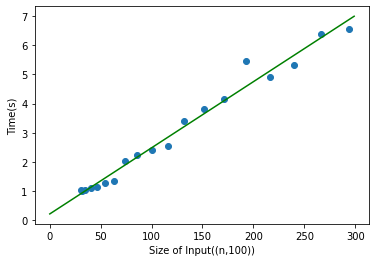

In [29]:
t = np.array(time)
inp = np.array(input_size)

plt.scatter(inp, t)

linear_model=np.polyfit(inp,t,1)
linear_model_fn=np.poly1d(linear_model)

x_s=np.arange(0,300)

plt.plot(x_s,linear_model_fn(x_s),color="green")
plt.xlabel("Size of Input((n,100))")
plt.ylabel("Time(s)")
plt.show()

The first value of the linear model is the slope and the second is the intercept.

In [20]:
linear_model

array([0.02263116, 0.22427572])

We try to predict the time that it takes to train an input size of 9000

In [32]:
def predict(linear_model, x):
    pre = linear_model[0]*x + linear_model[1]
    return(pre)

In [22]:
predict(linear_model, 9000)

203.90470995849947

Then lets try to calculate the actual value.

In [13]:
embedded_docs_combined.shape

(9562, 100)

In [16]:
0.94*embedded_docs_combined.shape[0]

8988.279999999999

In [8]:
cb = TimingCallback()
X_final=np.array(embedded_docs_combined) # Converting X and y as array which are embedded padded objects
y_final=np.array(df_combined['Fake-Real'])
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=1-0.94, random_state=42)
model.fit(X_train,y_train,epochs=5,batch_size=64, shuffle=True, callbacks=[cb],verbose=0)
print(sum(cb.logs))

214.92029780000001


The actual value is almost equivalent to our prediction.

Now, let's try to predict the time is needed for an input size of 5000

In [25]:
predict(linear_model, 5000)

113.3800725172214

The actual time

In [27]:
0.52*embedded_docs_combined.shape[0]

4972.24

In [28]:
X_final=np.array(embedded_docs_combined) # Converting X and y as array which are embedded padded objects
y_final=np.array(df_combined['Fake-Real'])
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=1-0.52, random_state=42)
model.fit(X_train,y_train,epochs=5,batch_size=64, shuffle=True, callbacks=[cb],verbose=0)
print(sum(cb.logs))

115.02064620000056


## Investigating input_size vs prediction_time

In [28]:
test_size = 0.1
input_size = list()
time_measurement = list()
X_final=np.array(embedded_docs_germanFakeNC) # Converting X and y as array which are embedded padded objects
y_final=np.array(df_germanFakeNC['Fake-Real'])
for i in range(0,500):
    X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=test_size, random_state=42)
    start = time.perf_counter()
    predicted_combined = model.predict(X_test)
    end = time.perf_counter()
    time_measurement.append(end-start)
    input_size.append(round(test_size*308))
    test_size = test_size + (i+1)/300
    if test_size >= 1 : 
        break

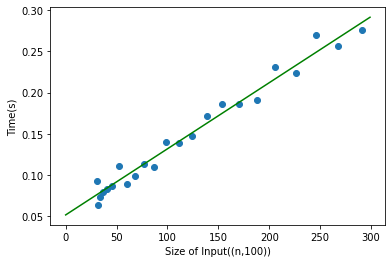

In [30]:
t = np.array(time_measurement)
inp = np.array(input_size)

plt.scatter(inp, t)

linear_model=np.polyfit(inp,t,1)
linear_model_fn=np.poly1d(linear_model)

x_s=np.arange(0,300)

plt.plot(x_s,linear_model_fn(x_s),color="green")
plt.xlabel("Size of Input((n,100))")
plt.ylabel("Time(s)")
plt.show()

In [33]:
predict(linear_model, 9000)

7.282344176241554

In [35]:
X_final=np.array(embedded_docs_combined) # Converting X and y as array which are embedded padded objects
y_final=np.array(df_combined['Fake-Real'])
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.94, random_state=42)
start = time.perf_counter()
model.predict(X_test)
end = time.perf_counter()
print(end-start)

8.02467069999966


In [37]:
predict(linear_model, 5000)

4.068520483263021

In [36]:
X_final=np.array(embedded_docs_combined) # Converting X and y as array which are embedded padded objects
y_final=np.array(df_combined['Fake-Real'])
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.52, random_state=42)
start = time.perf_counter()
model.predict(X_test)
end = time.perf_counter()
print(end-start)

4.788046399999985


In [38]:
linear_model

array([0.00080346, 0.05124087])